In [99]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [100]:
import elasticite as el
import numpy as np
duration = el.get_default_args(el.EdgeGrid.render)['duration']

## angles perpendiculaires

In [149]:
%%writefile ../scenario_line_geometry.py
#!/usr/bin/env python
# -*- coding: utf8 -*-

import elasticite as el
import numpy as np

class EdgeGrid(el.EdgeGrid):
    def champ(self):
        if self.structure: N_lame = self.N_lame-self.struct_N
        else: N_lame = self.N_lame

        force = np.zeros_like(self.lames[2, :N_lame])
        damp_min = 0.2
        damp_tau = 10.
        damp = lambda t: damp_min + (1.-damp_min)*np.exp(-np.abs(np.mod(t+self.period/2, self.period)-self.period/2)/damp_tau)

        smooth = lambda t: 1.-np.exp(-np.abs(np.mod(t+self.period/2, self.period)-self.period/2)**2/damp_tau**2)

        damp_angle_tau = 8.
        damp_angle = lambda t: 1.-np.exp(-(np.mod(t+self.period/2, self.period)-self.period/2)**2/2/damp_angle_tau**2)
        xf = lambda t: location[0]
        zf = lambda t: location[2] + 3.5 * np.sin(2*np.pi*(t)/self.period)

        noise = lambda t: .8 * smooth(t)#* np.exp((np.cos(2*np.pi*((t-0.) / 6. + x))-1.)/ .1**2)
        #damp = lambda t: 0.001 #* np.exp(np.cos(t / 6.) / 3.**2)
        colin_t = lambda t: -.2 * smooth(t) #*np.exp((np.cos(2*np.pi*((t-3.) / 6. + y))-1.)/ .3**2)
        colin_d = lambda d: np.exp(-d**2/2/.25**2) #np.exp(-np.log((d+1.e-12)/.05)**2/2/1.5)

        #delta_angle = np.mod(self.angle_relatif()-np.pi/3., 2*np.pi/3)
        delta_angle = self.angle_relatif()[:N_lame, :N_lame]-np.pi/2.
        #delta_angle *= np.sign(delta_angle)
        D = self.distance(do_torus=True)[:N_lame, :N_lame]
        force  += colin_t(self.t) * np.sum(np.sin(2*delta_angle)*colin_d(D), axis=1) * smooth(self.t)
        #force += force_/np.abs(force_**2).sum()
        force -= 7.5 * (np.mod(self.lames[2, :N_lame]+np.pi/2, np.pi) - np.pi/2) * (1- smooth(self.t) )
        force += noise(self.t)*np.pi*np.random.randn(N_lame)
        force -= damp(self.t) * self.lames[3, :N_lame]/self.dt
        return .01 * force
    

if __name__ == "__main__":
    import sys
    if len(sys.argv)>1: mode = sys.argv[1]
    else: mode = 'both'
    filename = None
    filename = 'mat/line_geometry.npy'
    e = EdgeGrid(N_lame=25, grid_type='line', mode=mode, verb=True, filename=filename, period=4*60.)
    el.main(e)

    

Overwriting ../scenario_line_geometry.py


In [150]:
%cd ..
!rm mat/line_geometry.npy
%run  scenario_line_geometry.py writer
%cd posts

/Users/laurentperrinet/cloud_nas/science/elasticte
recording at t= 0.0
recording at t= 0.0333333333333
recording at t= 0.0666666666667
recording at t= 0.1
recording at t= 0.133333333333
recording at t= 0.166666666667
recording at t= 0.2
recording at t= 0.233333333333
recording at t= 0.266666666667
recording at t= 0.3
recording at t= 0.333333333333
recording at t= 0.366666666667
recording at t= 0.4
recording at t= 0.433333333333
recording at t= 0.466666666667
recording at t= 0.5
recording at t= 0.533333333333
recording at t= 0.566666666667
recording at t= 0.6
recording at t= 0.633333333333
recording at t= 0.666666666667
recording at t= 0.7
recording at t= 0.733333333333
recording at t= 0.766666666667
recording at t= 0.8
recording at t= 0.833333333333
recording at t= 0.866666666667
recording at t= 0.9
recording at t= 0.933333333333
recording at t= 0.966666666667
recording at t= 1.0
recording at t= 1.03333333333
recording at t= 1.06666666667
recording at t= 1.1
recording at t= 1.133333333

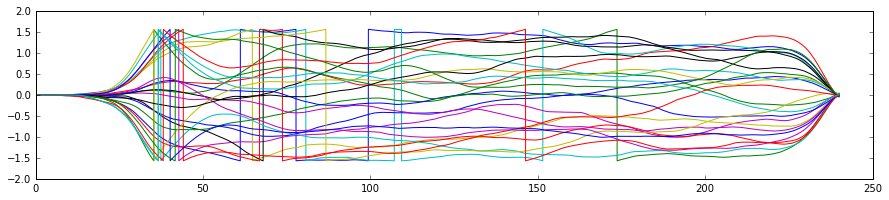

In [107]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

z = np.load('../mat/line_geometry.npy')
fig, ax = plt.subplots(figsize=(15, 3))
#_ = ax.plot(z[:, 0])
_ = ax.plot(z[:, 0], z[:, 1:])

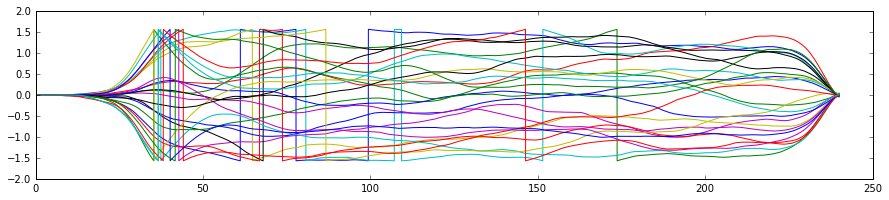

In [107]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

z = np.load('../mat/line_geometry.npy')
fig, ax = plt.subplots(figsize=(15, 3))
#_ = ax.plot(z[:, 0])
_ = ax.plot(z[:, 0], z[:, 1:])

## 45 deg


In [142]:
%%writefile ../scenario_line_geometry_45deg.py
#!/usr/bin/env python
# -*- coding: utf8 -*-

import elasticite as el
import numpy as np

class EdgeGrid(el.EdgeGrid):
    def champ(self):
        if self.structure: N_lame = self.N_lame-self.struct_N
        else: N_lame = self.N_lame

        force = np.zeros_like(self.lames[2, :N_lame])
        damp_min = 0.4
        damp_tau = 4.
        damp = lambda t: damp_min + (1.-damp_min)*np.exp(-np.abs(np.mod(t+self.period/2, self.period)-self.period/2)/damp_tau)

        smooth = lambda t: 1.-np.exp(-np.abs(np.mod(t+self.period/2, self.period)-self.period/2)**2/damp_tau**2)
        on_off = lambda t, freq: (np.sin(2*np.pi*t/self.period*freq) > 0.)

        noise = lambda t: .8 * smooth(t)
        
        force -= 7.5 * (np.mod(self.lames[2, :N_lame]+np.pi/2, np.pi) - np.pi/2 -np.pi/4) *smooth(self.t) *on_off(self.t, 3)
        force -= 40 * (np.mod(self.lames[2, :N_lame]+np.pi/2, np.pi) - np.pi/2) * (1- smooth(self.t) ) *(1-on_off(self.t, 3))
        force += noise(self.t)*np.pi*np.random.randn(N_lame)
        force -= damp(self.t) * self.lames[3, :N_lame]/self.dt
        return .01 * force
    

if __name__ == "__main__":
    import sys
    if len(sys.argv)>1: mode = sys.argv[1]
    else: mode = 'both'
    filename = None
    filename = 'mat/line_geometry_45deg.npy'
    e = EdgeGrid(N_lame=25, grid_type='line', mode=mode, verb=False, filename=filename, period=4*60.)
    el.main(e)

    

Overwriting ../scenario_line_geometry_45deg.py


In [143]:
%cd ..
!rm mat/line_geometry_45deg.npy
%run  scenario_line_geometry_45deg.py writer
%cd posts

/Users/laurentperrinet/cloud_nas/science/elasticte
/Users/laurentperrinet/cloud_nas/science/elasticte/posts


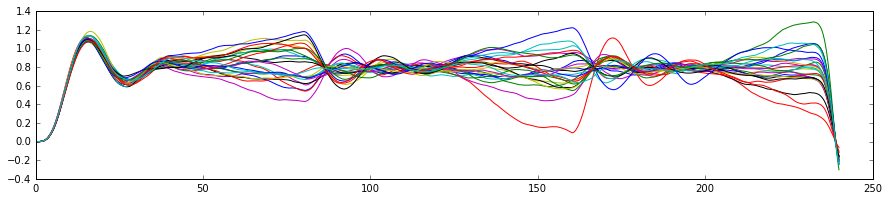

In [144]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

z = np.load('../mat/line_geometry_45deg.npy')
fig, ax = plt.subplots(figsize=(15, 3))
#_ = ax.plot(z[:, 0])
_ = ax.plot(z[:, 0], z[:, 1:])

## git

In [146]:
!git add  ../mat/line_geometry_45deg.npy  ../scenario_line_geometry_45deg.py

!git s

A  ../mat/line_geometry_45deg.npy
 M ../mat/master.npy
 M "2015-11-26 \303\251lasticit\303\251 - sc\303\251nario montage.ipynb"
 M "2015-11-27 \303\251lasticit\303\251, geometrie.ipynb"
A  ../scenario_line_geometry_45deg.py
 M ../scenario_line_master.py
 M ../src/elasticite.py


In [147]:
!git commit -am' scenario geometry  45deg '

[master 6b3ea36]  scenario geometry  45deg
 7 files changed, 864 insertions(+), 641 deletions(-)
 create mode 100644 mat/line_geometry_45deg.npy
 rewrite "posts/2015-11-26 \303\251lasticit\303\251 - sc\303\251nario montage.ipynb" (91%)
 rewrite "posts/2015-11-27 \303\251lasticit\303\251, geometrie.ipynb" (90%)
 create mode 100644 scenario_line_geometry_45deg.py


In [148]:
! git push

Counting objects: 12, done.
Delta compression using up to 4 threads.
Compressing objects: 100% (12/12), done.
Writing objects: 100% (12/12), 34.13 MiB | 8.35 MiB/s, done.
Total 12 (delta 5), reused 0 (delta 0)
To git@git.framasoft.org:laurentperrinet/elasticte.git
   29e2555..6b3ea36  master -> master
